In [14]:
# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import sys
import os
import re
import shutil
import string

print("Python path:", sys.executable)
print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
print("Matplotlib version:", mpl.__version__)
print("Numpy version:", np.version.version)
print("Pandas version:", pd.__version__)
print("Sklearn version:", sklearn.__version__)

Python path: c:\program files\python37\python.exe
Python version: 3.7.0 (v3.7.0:1bf9cc5093, Jun 27 2018, 04:59:51) [MSC v.1914 64 bit (AMD64)]
TensorFlow version: 2.5.0
Matplotlib version: 3.4.2
Numpy version: 1.19.5
Pandas version: 1.0.3
Sklearn version: 0.24.2


In [15]:
# load csv
df = pd.read_csv('kaggle1.csv', engine='python')
df.head(5)


,S.No.,HSCode,Commodity,Y1819,PercentShare19,Y1920P,PercentShare20,PercentGrowth,Clean Commodity
0,1,1012100,Pure-Bred Breeding Horses,0.00,0.0000,209.12,0.0001,0,Pure-Bred Breeding Horses
1,2,1012910,Horses For Polo,105.99,0.0000,72.70,0.0000,0,Horses For Polo
2,3,1012990,Horses,1683.48,0.0005,956.18,0.0003,0,Horses
3,4,1019090,Mules,2.66,0.0000,47.89,0.0000,0,Mules
4,5,1022110,Bulls For Breeding,0.00,0.0000,117.82,0.0000,0,Bulls For Breeding


In [16]:
# Preprocess the CSV
# Throw unused tables
# Add new tables if required

# see https://www.customslegaloffice.com/global/the-fundamentals-of-hs-classification/

HSCodeDescDict = {1: "Chapter 01-05: Live Animals; Animal Products", 
                  2: "Chapter 06-15: Vegetable Products",
                  3: "Chapter 16-24: Food stuffs",
                  4: "Chapter 25-27: Mineral Products",
                  5: "Chapter 28-38: Chemicals && Allied Industries",
                  6: "Chapter 39-40: Plastic or Rubbers",
                  7: "Chapter 41-43: Raw Hides, Skins, Leather & Furs",
                  8: "Chapter 44-49: Wood & Wood Products",
                  9: "Chapter 50-63: Textiles",
                  10: "Chapter 64-67: Footwear / Headgear",
                  11: "Chapter 68-71: Stone / Glass",
                  12: "Chapter 72-83: Metals",
                  13: "Chapter 84-85: Machinery / Electrical",
                  14: "Chapter 86-89: Transportation",
                  15: "Chapter 90-97: Miscellaneous",
                  16: "Chapter 98-99: Service"}

def HSCodeDescription(row):
  section = int(row['HSCodeChapter'])
  if 1 <= section and section < 6:
    return HSCodeDescDict[1]
  elif 6 <= section and section < 16:
    return HSCodeDescDict[2]
  elif 16 <= section and section < 25:
    return HSCodeDescDict[3]
  elif 25 <= section and section < 28:
    return HSCodeDescDict[4]
  elif 28 <= section and section < 39:
    return HSCodeDescDict[5]
  elif 39 <= section and section < 41:
    return HSCodeDescDict[6]
  elif 41 <= section and section < 44:
    return HSCodeDescDict[7]
  elif 44 <= section and section < 50:
    return HSCodeDescDict[8]
  elif 50 <= section and section < 64:
    return HSCodeDescDict[9]
  elif 64 <= section and section < 68:
    return HSCodeDescDict[10]
  elif 68 <= section and section < 72:
    return HSCodeDescDict[11]
  elif 72 <= section and section < 84:
    return HSCodeDescDict[12]
  elif 84 <= section and section < 86:
    return HSCodeDescDict[13]
  elif 86 <= section and section < 90:
    return HSCodeDescDict[14]
  elif 90 <= section and section < 98:
    return HSCodeDescDict[15]
  elif 98 <= section and section < 100:
    return HSCodeDescDict[16]
  else:
    return "Unknown"

from io import StringIO
col = ['Commodity', 'HSCode']
df = df[col]
df = df[pd.notnull(df['HSCode'])]
#df['HSCodeType'] = type(df['HSCode'])

df['HSCodeChapter'] = df['HSCode'].astype(str).str[:-6]
df['HSCodeChapterDetail'] = df['HSCode'].astype(str).str[-6:]
df['HSCodeChapterDescription'] = df.apply(lambda row: HSCodeDescription(row), axis=1)
df.head(4000)


#sectiontry = int(df.iloc[3995]['HSCodeChapter'])
#if(39 <= sectiontry and sectiontry < 41 ):
#  print("success")
#else:
#  print("fail")

,Commodity,HSCode,HSCodeChapter,HSCodeChapterDetail,HSCodeChapterDescription
0,Pure-Bred Breeding Horses,1012100,1,012100,Chapter 01-05: Live Animals; Animal Products
1,Horses For Polo,1012910,1,012910,Chapter 01-05: Live Animals; Animal Products
2,Horses,1012990,1,012990,Chapter 01-05: Live Animals; Animal Products
3,Mules,1019090,1,019090,Chapter 01-05: Live Animals; Animal Products
4,Bulls For Breeding,1022110,1,022110,Chapter 01-05: Live Animals; Animal Products
...,...,...,...,...,...
3995,Rubber Ring(O-Ring),40169320,40,169320,Chapter 39-40: Plastic or Rubbers
3996,"Rubber Seals(Oil Seals,Etc)",40169330,40,169330,Chapter 39-40: Plastic or Rubbers
3997,Gaskets,40169340,40,169340,Chapter 39-40: Plastic or Rubbers
3998,Washers,40169350,40,169350,Chapter 39-40: Plastic or Rubbers


In [17]:

df['HSCodeChapterId'] = df['HSCodeChapterDescription'].factorize()[0]
category_id_df = df[['HSCodeChapterDescription', 'HSCodeChapterId']].drop_duplicates().sort_values('HSCodeChapterId')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['HSCodeChapterId', 'HSCodeChapterDescription']].values)
df.head(7000)

,Commodity,HSCode,HSCodeChapter,HSCodeChapterDetail,HSCodeChapterDescription,HSCodeChapterId
0,Pure-Bred Breeding Horses,1012100,1,012100,Chapter 01-05: Live Animals; Animal Products,0
1,Horses For Polo,1012910,1,012910,Chapter 01-05: Live Animals; Animal Products,0
2,Horses,1012990,1,012990,Chapter 01-05: Live Animals; Animal Products,0
3,Mules,1019090,1,019090,Chapter 01-05: Live Animals; Animal Products,0
4,Bulls For Breeding,1022110,1,022110,Chapter 01-05: Live Animals; Animal Products,0
...,...,...,...,...,...,...
6995,Bright Bars-Chromium Type,72210011,72,210011,Chapter 72-83: Metals,11
6996,Brght Bars Nckl Chrm Astntc Type,72210012,72,210012,Chapter 72-83: Metals,11
6997,Others,72210019,72,210019,Chapter 72-83: Metals,11
6998,Brght Bars N.E.S.,72210090,72,210090,Chapter 72-83: Metals,11


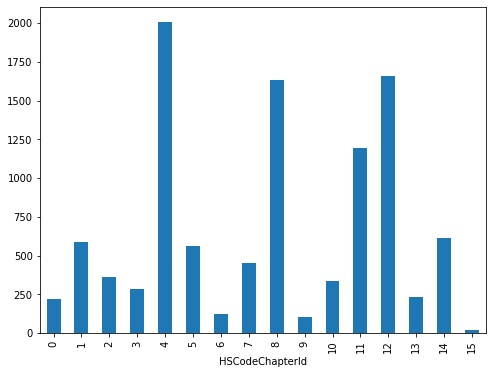

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('HSCodeChapterId').HSCode.count().plot.bar(ylim=0)
plt.show()

In [19]:
# This is incorrect... using TF-IDF is not the way (because it uses frequency of certain words to determine category)
# we need to somehow use Short text to classify...

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Commodity).toarray()
labels = df.HSCodeChapterId
features.shape

(10380, 2417)

In [20]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Commodity, HSCodeChapterId in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == HSCodeChapterId)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Commodity))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Chapter 01-05: Live Animals; Animal Products':
  . Most correlated unigrams:
. fillets
. frozen
  . Most correlated bigrams:
. frozen fillets
. fresh chilled
# 'Chapter 06-15: Vegetable Products':
  . Most correlated unigrams:
. dried
. seeds
  . Most correlated bigrams:
. edble grade
. crushed ground
# 'Chapter 16-24: Food stuffs':
  . Most correlated unigrams:
. holding
. tobacco
  . Most correlated bigrams:
. containers holding
. holding ltr
# 'Chapter 25-27: Mineral Products':
  . Most correlated unigrams:
. calcined
. ores
  . Most correlated bigrams:
. manganese ore
. ores concentrates
# 'Chapter 28-38: Chemicals && Allied Industries':
  . Most correlated unigrams:
. salts
. acid
  . Most correlated bigrams:
. acid salts
. non azo
# 'Chapter 39-40: Plastic or Rubbers':
  . Most correlated unigrams:
. resins
. shts
  . Most correlated bigrams:
. rigid plain
. pltes shts
# 'Chapter 41-43: Raw Hides, Skins, Leather & Furs':
  . Most correlated unigrams:
. leather
. skins
  . Most

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Commodity'], df['HSCodeChapterId'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

pd.DataFrame(y_train)


,HSCodeChapterId
5062,8
8326,12
1589,4
5003,8
326,1
...,...
9225,12
4859,8
3264,4
9845,14


In [22]:
print(clf.predict(count_vect.transform(['Mules'])))

[4]


In [23]:
df.head(4000)

,Commodity,HSCode,HSCodeChapter,HSCodeChapterDetail,HSCodeChapterDescription,HSCodeChapterId
0,Pure-Bred Breeding Horses,1012100,1,012100,Chapter 01-05: Live Animals; Animal Products,0
1,Horses For Polo,1012910,1,012910,Chapter 01-05: Live Animals; Animal Products,0
2,Horses,1012990,1,012990,Chapter 01-05: Live Animals; Animal Products,0
3,Mules,1019090,1,019090,Chapter 01-05: Live Animals; Animal Products,0
4,Bulls For Breeding,1022110,1,022110,Chapter 01-05: Live Animals; Animal Products,0
...,...,...,...,...,...,...
3995,Rubber Ring(O-Ring),40169320,40,169320,Chapter 39-40: Plastic or Rubbers,5
3996,"Rubber Seals(Oil Seals,Etc)",40169330,40,169330,Chapter 39-40: Plastic or Rubbers,5
3997,Gaskets,40169340,40,169340,Chapter 39-40: Plastic or Rubbers,5
3998,Washers,40169350,40,169350,Chapter 39-40: Plastic or Rubbers,5


In [87]:

# add columns to "tokenize" the words
import nltk

def tokenizeAndRemoveStopWords(row):
  tokenizerWithoutPunctuation = nltk.RegexpTokenizer(r"\w+")
  tokens_unclean = tokenizerWithoutPunctuation.tokenize(row['Commodity'])
  return tokens_unclean 

df['tokens'] = df.apply(lambda row: tokenizeAndRemoveStopWords(row), axis=1)
df.head(10380)


,Commodity,HSCode,HSCodeChapter,HSCodeChapterDetail,HSCodeChapterDescription,HSCodeChapterId,tokens
0,Pure-Bred Breeding Horses,1012100,1,012100,Chapter 01-05: Live Animals; Animal Products,0,"[Pure, Bred, Breeding, Horses]"
1,Horses For Polo,1012910,1,012910,Chapter 01-05: Live Animals; Animal Products,0,"[Horses, For, Polo]"
2,Horses,1012990,1,012990,Chapter 01-05: Live Animals; Animal Products,0,[Horses]
3,Mules,1019090,1,019090,Chapter 01-05: Live Animals; Animal Products,0,[Mules]
4,Bulls For Breeding,1022110,1,022110,Chapter 01-05: Live Animals; Animal Products,0,"[Bulls, For, Breeding]"
...,...,...,...,...,...,...,...
10375,Samples,99930010,99,930010,Chapter 98-99: Service,15,[Samples]
10376,Returned Goods,99930020,99,930020,Chapter 98-99: Service,15,"[Returned, Goods]"
10377,Special Transactions N.E.S.,99930090,99,930090,Chapter 98-99: Service,15,"[Special, Transactions, N, E, S]"
10378,Unspecified Items,99999998,99,999998,Chapter 98-99: Service,15,"[Unspecified, Items]"


In [44]:
from gensim.models import word2vec

arr = df['tokens'].to_numpy()
pd.DataFrame(arr)

,0
0,"[Pure, Bred, Breeding, Horses]"
1,"[Horses, For, Polo]"
2,[Horses]
3,[Mules]
4,"[Bulls, For, Breeding]"
...,...
10375,[Samples]
10376,"[Returned, Goods]"
10377,"[Special, Transactions, N, E, S]"
10378,"[Unspecified, Items]"


In [75]:
embedding_size = 30    #Dictionaries with up to 40,000 words
min_count = 1    # Use only words that occur at least n times

w2v_model = word2vec.Word2Vec(arr,min_count=1,vector_size= 200,workers=3, window =10, sg = 1)
w2v_weight = w2v_model.wv.vectors

#type(w2v_model)
pd.DataFrame(w2v_weight)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.291465,-0.072420,-0.175921,0.099994,0.186782,-0.060077,0.023643,0.500829,-0.140454,-0.008005,...,0.113948,0.328929,0.007335,-0.327301,0.245964,0.058813,0.061568,-0.023182,-0.081352,-0.083191
1,-0.366857,-0.015993,-0.065110,0.159481,0.237726,-0.119486,-0.056771,0.295714,-0.078002,0.143326,...,0.251457,0.244616,0.079927,-0.276118,0.226596,-0.023996,0.099887,-0.116721,-0.094892,-0.079293
2,-0.294029,0.006680,-0.090232,0.125576,0.210550,-0.114594,-0.042946,0.303708,-0.100622,0.069809,...,0.218431,0.207269,0.018344,-0.247116,0.199837,0.005074,0.061301,-0.103923,-0.040100,-0.068652
3,-0.267375,-0.074276,-0.168114,0.129594,0.190457,-0.052357,0.027721,0.439154,-0.123941,-0.022022,...,0.091922,0.303811,0.004350,-0.260842,0.246152,0.008109,0.088916,-0.042637,-0.043842,-0.137910
4,-0.296659,-0.097158,-0.069208,0.003120,0.109795,-0.009614,0.032754,0.392160,-0.176435,0.157449,...,0.223703,0.285274,-0.003029,-0.232583,0.287991,-0.076122,0.059985,-0.033338,-0.059040,-0.048775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9762,-0.017036,-0.003084,-0.001797,-0.001014,0.005884,0.001734,0.003244,0.017857,-0.007708,0.000025,...,0.003597,0.008588,-0.000255,-0.011959,0.013013,-0.001844,-0.000577,-0.003183,0.000138,-0.009409
9763,-0.010479,-0.009126,-0.006959,0.007600,0.014121,-0.004529,0.004633,0.023887,-0.012339,-0.003883,...,0.006833,0.014281,0.001905,-0.018446,0.009770,-0.005710,0.004217,-0.006371,0.001165,-0.007555
9764,-0.020884,-0.003934,-0.008301,0.001753,0.011173,-0.004956,-0.001315,0.037610,-0.009970,0.005196,...,0.005792,0.020956,-0.003984,-0.014189,0.016786,0.001341,0.002141,-0.003120,0.005298,-0.007201
9765,-0.044710,-0.007499,-0.018330,0.009619,0.032515,-0.006140,0.003001,0.076781,-0.032255,0.001400,...,0.023400,0.042054,-0.002463,-0.045631,0.037444,-0.003698,0.014254,-0.011450,0.010467,-0.024814


In [80]:
w2v_model.wv.most_similar("Car")

[('1500', 0.9992429614067078),
 ('2500', 0.9989796876907349),
 ('Spark', 0.9988721013069153),
 ('Cmbnd', 0.9988190531730652),
 ('Engns', 0.9987890720367432),
 ('1500Cc', 0.9987874627113342),
 ('Brdcst', 0.9987510442733765),
 ('Genrtng', 0.9986993074417114),
 ('Elec', 0.9986883997917175),
 ('Engn', 0.9986655116081238)]

In [85]:
hscode_y = df['HSCode'].to_numpy()
pd.DataFrame(hscode_y)

,0
0,1012100
1,1012910
2,1012990
3,1019090
4,1022110
...,...
10375,99930010
10376,99930020
10377,99930090
10378,99999998


In [ ]:
def one_hot(y):
    y = y.astype(dtype='int64')
    label_binarizer = sklearn.preprocessing.LabelBinarizer()
    label_binarizer.fit(range(max(y) + 1))
    one_hot_y = label_binarizer.transform(y)
    return one_hot_y

hscode_y_one_hot = one_hot(hscode_y)
pd.DataFrame(hscode_y_one_hot)